<h1>Project 1</h1>

Problem: atypical employee departures are costly for government agencies because (i) they need to start a hiring process to replace the previous employee, and (ii) there is an additional cost of lost knowledge and experience as a experienced employees leave.
<br><br>
Applied machine leaning solution: create a model that can predict, given some context, whether an employee will leave within the same fiscal year
<br><br>
Actionable insights: based on the importance of different features in the model, can see how to make the target employee stay

<br><br>
Will look only at admin for children's svcs

NYC fiscal year from July 1 to June 30
<hr>

In [42]:
import requests
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

In [43]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from scipy.stats import bernoulli
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_selection import RFE

<h2>1. Exploratory data analysis</h2>

In [44]:
nyc_payroll = []
offset = 0
url = 'https://data.cityofnewyork.us/resource/k397-673e.json'
while True:
  print(f"offset is {offset}")
  params = {
      'agency_name': "ADMIN FOR CHILDREN'S SVCS",
      'pay_basis': 'per Annum',
      '$offset': offset
  }
  response = requests.get(url=url, params=params)
  temp = response.json()
  offset += len(temp)
  if len(temp)==0: break
  nyc_payroll.extend(temp)

if len(nyc_payroll) != offset:
  print(f"Something's wrong with the data collection, collected {len(nyc_payroll)} entires, but expected {offset}!")
else:
  nyc_payroll = pd.DataFrame(nyc_payroll)

offset is 0
offset is 1000
offset is 2000
offset is 3000
offset is 4000
offset is 5000
offset is 6000
offset is 7000
offset is 8000
offset is 9000
offset is 10000
offset is 11000
offset is 12000
offset is 13000
offset is 14000
offset is 15000
offset is 16000
offset is 17000
offset is 18000
offset is 19000
offset is 20000
offset is 21000
offset is 22000
offset is 23000
offset is 24000
offset is 25000
offset is 26000
offset is 27000
offset is 28000
offset is 29000
offset is 30000
offset is 31000
offset is 32000
offset is 33000
offset is 34000
offset is 35000
offset is 36000
offset is 37000
offset is 38000
offset is 39000
offset is 40000
offset is 41000
offset is 42000
offset is 43000
offset is 44000
offset is 45000
offset is 46000
offset is 47000
offset is 48000
offset is 49000
offset is 50000
offset is 51000
offset is 52000
offset is 53000
offset is 54000
offset is 55000
offset is 56000
offset is 57000
offset is 58000
offset is 59000
offset is 60000
offset is 61000
offset is 62000
offse

In [45]:
#85917 inputs from 2014 to 2025
df = pd.DataFrame(nyc_payroll)

In [46]:
len(df['fiscal_year'].unique()), df['fiscal_year'].unique() #from 2014 to 2024

(11,
 array(['2020', '2021', '2022', '2023', '2016', '2015', '2014', '2017',
        '2018', '2019', '2024'], dtype=object))

In [47]:
df['leave_status_as_of_june_30'].isin(['ACTIVE', 'CEASED']).sum()

82689

In [48]:
df = df[df['leave_status_as_of_june_30'].isin(['ACTIVE', 'CEASED'])]
df.shape

(82689, 17)

In [49]:
#see how many active and ceased
print(df['leave_status_as_of_june_30'].value_counts())
df['leave_status_as_of_june_30'].value_counts()/df.shape[0]

leave_status_as_of_june_30
ACTIVE    69581
CEASED    13108
Name: count, dtype: int64


,count
leave_status_as_of_june_30,
ACTIVE,0.841478
CEASED,0.158522


<h2>
Observations on my data set
<ul><li>total of 82689 data points
<li>imbalanced, with 84% active and 16% ceased

In [50]:
#remove payroll_number, agency_name, last_name, first_name
to_remove = ['payroll_number', 'agency_name', 'last_name', 'first_name', 'pay_basis', 'mid_init']
df.drop(columns=to_remove, inplace=True)

In [51]:
df['active'] = np.where(df['leave_status_as_of_june_30']=='ACTIVE',1,0)
df.drop(columns=['leave_status_as_of_june_30'], inplace=True)
df.rename(columns={"leave": "active"})
df.reset_index()

,index,fiscal_year,agency_start_date,work_location_borough,title_description,base_salary,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,active
0,0,2020,2017-03-06T00:00:00.000,MANHATTAN,COMMISSIONER OF CHILDREN'S SERVICES,243171.00,1820.00,239475.95,0.00,0.00,1000.00,1
1,1,2020,2014-02-04T00:00:00.000,MANHATTAN,EXECUTIVE DEPUTY ADMINISTRATOR,232723.00,1820.00,229186.89,0.00,0.00,0.00,1
2,2,2020,2012-02-06T00:00:00.000,MANHATTAN,ASSISTANT COMMISSIONER FOR MANAGEMENT ACD-DOSS,226745.00,1820.00,223299.81,0.00,0.00,0.00,1
3,3,2020,2017-05-22T00:00:00.000,MANHATTAN,CITY MEDICAL DIRECTOR,225591.00,1820.00,222162.99,0.00,0.00,0.00,1
4,4,2020,1996-06-23T00:00:00.000,MANHATTAN,EXECUTIVE AGENCY COUNSEL,211335.00,1820.00,208123.97,0.00,0.00,1294.87,1
...,...,...,...,...,...,...,...,...,...,...,...,...
82684,85912,2024,1996-06-23T00:00:00.000,MANHATTAN,DEPUTY COMMISSIONER,213910.00,0,0.00,0,0.00,83634.38,0
82685,85913,2024,1996-06-23T00:00:00.000,MANHATTAN,DIRECTOR OF FIELD OPERATIONS,142273.00,0,0.00,0,0.00,95736.99,0
82686,85914,2024,1996-06-23T00:00:00.000,MANHATTAN,CHILD PROTECTIVE SPECIALIST SUPERVISOR,75998.00,1470.00,57242.47,0,0.00,110997.66,0
82687,85915,2024,2008-01-07T00:00:00.000,BROOKLYN,EXECUTIVE AGENCY COUNSEL,139472.00,0,0.00,0,0.00,120947.38,0


In [52]:
#is the base salary the same for each title_description?
df['title_description'].value_counts(ascending=False).head()

,count
title_description,
CHILD PROTECTIVE SPECIALIST,27149
CHILD PROTECTIVE SPECIALIST SUPERVISOR,6265
YOUTH DEVELOPMENT SPECIALIST,4289
COMMUNITY COORDINATOR,3817
ADMINISTRATIVE DIRECTOR OF SOCIAL SERVICES,3165


In [53]:
cps = df[df['title_description']=='COMMUNITY COORDINATOR']
print(cps.shape)
cps['base_salary'].value_counts(ascending=False).head()

(3817, 11)


,count
base_salary,
62215.00,284
57916.00,140
70022.00,92
56229.00,86
60403.00,75


Interesting, the base_salary is different even if the title_description is the same. I'll probably generate a feature diff_from_mean_salary and std_from_mean_salary to calculate the difference/std away from the base salary of the title.

In [54]:
test = df['base_salary'].astype(float) * df['regular_hours'].astype(float) - df['regular_gross_paid'].astype(float)

In [55]:
test.value_counts()

,count
0.000000e+00,1215
9.039940e+07,1164
1.097350e+08,1005
1.097350e+08,955
9.716802e+07,784
...,...
3.621400e+06,1
6.150010e+06,1
6.268462e+07,1
1.113485e+08,1


In [56]:
#split into test and training set
#make sure stratified because imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.33, stratify=df.iloc[:, -1], random_state=42)

<h2>2. Feature generation on the training dataset

In [57]:
numerical_cols = ['base_salary',
       'regular_hours', 'regular_gross_paid', 'ot_hours', 'total_ot_paid',
       'total_other_pay', 'time_in_pos_months']

all_num_cols = numerical_cols + ['std_from_mean_salary', 'std_from_mean_reg_hours', 'std_from_mean_ot_hours', 'overall_pay', 'std_from_mean_overall_pay']

In [58]:
#generates time_in_pos_months and dummies for work_location_borough, removes redundant features, converts numerical to float
def preprocess_data(X, test=False, training_vals=None):
  X = X.copy()

  means_and_std = {}

  #generate time_in_pos
  X['agency_start_date'] = pd.to_datetime(X['agency_start_date'].str[:10])
  X['curr_date'] = pd.to_datetime(X['fiscal_year'].astype(str) + '-06-30')
  X['time_in_pos_months'] = (X['curr_date'].dt.year - X['agency_start_date'].dt.year) * 12 + \
                           (X['curr_date'].dt.month - X['agency_start_date'].dt.month)

  #get dummy variables
  X = pd.get_dummies(X, columns=['work_location_borough'], dtype=float)

  #convert all to type float
  X = X.astype({col: float for col in numerical_cols})

  #(i) FOR BASE_SALARY
  if test:
    X['std_from_mean_salary'] = np.where(
        X['title_description'].map(training_vals['salary_std_for_titles']).fillna(1) != 0,
        (X['base_salary'] - X['title_description'].map(training_vals['salary_means_for_titles'])) /
        X['title_description'].map(training_vals['salary_std_for_titles']).fillna(1),  #replace nan std with 1
        0)
    X['std_from_mean_salary'] = np.where(np.isnan(X['std_from_mean_salary']), 0, X['std_from_mean_salary'])
  else:
    #generate mean base salary for each title
    salary_means_for_titles = X.groupby('title_description')['base_salary'].mean().to_dict()
    means_and_std['salary_means_for_titles'] = salary_means_for_titles
    #generate std_from_mean_salary
    salary_std_for_titles = X.groupby('title_description')['base_salary'].std().to_dict()
    means_and_std['salary_std_for_titles'] = salary_std_for_titles
    X['std_from_mean_salary'] = np.where(
      X['title_description'].map(salary_std_for_titles).fillna(1) != 0,  #ensure std deviation exists
      (X['base_salary'] - X['title_description'].map(salary_means_for_titles)) /
      X['title_description'].map(salary_std_for_titles).fillna(1),  #replace nan std with 1
      0
    )

  #(ii) FOR REGULAR_HOURS
  if test:
    X['std_from_mean_reg_hours'] = np.where(
        X['title_description'].map(training_vals['reg_hours_std_for_titles']).fillna(1) != 0,
        (X['regular_hours'] - X['title_description'].map(training_vals['reg_hours_means_for_titles'])) /
        X['title_description'].map(training_vals['reg_hours_std_for_titles']).fillna(1),  #replace nan std with 1
        0)
    X['std_from_mean_reg_hours'] = np.where(np.isnan(X['std_from_mean_reg_hours']), 0, X['std_from_mean_reg_hours'])
  else:
    #generate diff_from_mean_reg_hours
    reg_hours_means_for_titles = X.groupby('title_description')['regular_hours'].mean().to_dict()
    means_and_std['reg_hours_means_for_titles'] = reg_hours_means_for_titles

    #generate std_from_mean_reg_hours
    reg_hours_std_for_titles = X.groupby('title_description')['regular_hours'].std().to_dict()
    means_and_std['reg_hours_std_for_titles'] = reg_hours_std_for_titles
    X['std_from_mean_reg_hours'] = np.where(
        X['title_description'].map(reg_hours_std_for_titles).fillna(1) != 0,
        (X['regular_hours'] - X['title_description'].map(reg_hours_means_for_titles)) /
        X['title_description'].map(reg_hours_std_for_titles).fillna(1),
        0
    )

  #(iii) FOR OT_HOURS
  if test:
    X['std_from_mean_ot_hours'] = np.where(
        X['title_description'].map(training_vals['ot_hours_std_for_titles']).fillna(1) != 0,
        (X['ot_hours'] - X['title_description'].map(training_vals['ot_hours_std_for_titles'])) /
        X['title_description'].map(training_vals['ot_hours_std_for_titles']).fillna(1),  #replace nan std with 1
        0)
    X['std_from_mean_ot_hours'] = np.where(np.isnan(X['std_from_mean_ot_hours']), 0, X['std_from_mean_ot_hours'])
  else:
    ot_hours_means_for_titles = X.groupby('title_description')['ot_hours'].mean().to_dict()
    means_and_std['ot_hours_means_for_titles'] = ot_hours_means_for_titles

    #generate std_from_mean_ot_hours
    ot_hours_std_for_titles = X.groupby('title_description')['ot_hours'].std().to_dict()
    means_and_std['ot_hours_std_for_titles'] = ot_hours_std_for_titles
    X['std_from_mean_ot_hours'] = np.where(
        X['title_description'].map(ot_hours_std_for_titles).fillna(1) != 0,
        (X['ot_hours'] - X['title_description'].map(ot_hours_means_for_titles)) /
        X['title_description'].map(ot_hours_std_for_titles).fillna(1),
        0
    )

  #(iv) overall pay
  X['overall_pay'] = X['total_ot_paid'] + X['regular_gross_paid'] + X['total_other_pay']

  if test:
    X['std_from_mean_overall_pay'] = np.where(
        X['title_description'].map(training_vals['overall_pay_std_for_titles']).fillna(1) != 0,
        (X['ot_hours'] - X['title_description'].map(training_vals['overall_pay_means_for_titles'])) /
        X['title_description'].map(training_vals['overall_pay_std_for_titles']).fillna(1),  #replace nan std with 1
        0)
    X['std_from_mean_overall_pay'] = np.where(np.isnan(X['std_from_mean_overall_pay']), 0, X['std_from_mean_overall_pay'])
  else:
    overall_pay_means_for_titles = X.groupby('title_description')['overall_pay'].mean().to_dict()
    means_and_std['overall_pay_means_for_titles'] = overall_pay_means_for_titles
    #generate std for overall pay
    overall_pay_std_for_titles = X.groupby('title_description')['ot_hours'].std().to_dict()
    means_and_std['overall_pay_std_for_titles'] = overall_pay_std_for_titles
    X['std_from_mean_overall_pay'] = np.where(
        X['title_description'].map(overall_pay_std_for_titles).fillna(1) != 0,
        (X['overall_pay'] - X['title_description'].map(overall_pay_means_for_titles)) /
        X['title_description'].map(overall_pay_std_for_titles).fillna(1),
        0
    )
  #remove job description and agency_start_date
  X.drop(columns=['title_description', 'agency_start_date', 'curr_date', 'fiscal_year'], inplace=True)

  X.astype(float)

  return X, means_and_std

In [59]:
X_train_processed, means_and_std = preprocess_data(X_train)

<h2>(a) OLS initial test with dummies

In [73]:
#just throw into an OLS to see what the results are first
#standardize all numerical cols (including the feature generated ones)
scaler = StandardScaler()
X_train_processed[all_num_cols] = scaler.fit_transform(X_train_processed[all_num_cols])
ols_model_dummies = sm.OLS(y_train, X_train_processed).fit()
ols_model_dummies.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 active   R-squared (uncentered):                   0.876
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                          2.447e+04
Date:                Wed, 12 Mar 2025   Prob (F-statistic):                        0.00
Time:                        17:46:24   Log-Likelihood:                         -15995.
No. Observations:               55401   AIC:                                  3.202e+04
Df Residuals:                   55385   BIC:                                  3.216e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
base_salary                         0.0382      0.004      8.577      0.000       0.029       0.047
regular_hours                       0.3088      0.005     60.971      0.000       0.299       0.319
regular_gross_paid                 -0.0345      0.004     -9.042      0.000      -0.042      -0.027
ot_hours                           -0.0104      0.005     -1.965      0.049      -0.021   -2.84e-05
total_ot_paid                       0.0192      0.005      3.656      0.000       0.009       0.030
total_other_pay                    -0.0020      0.002     -1.327      0.185      -0.005       0.001
time_in_pos_months                 -0.0156      0.002     -9.303      0.000      -0.019      -0.012
work_location_borough_BRONX         0.8575      0.003    249.425      0.000       0.851       0.864
work_location_borough_BROOKLYN      0.8550      0.003    258.499      0.000       0.849       0.862
work_location_borough_MANHATTAN     0.8377      0.002    396.572      0.000       0.834       0.842
work_location_borough_QUEENS        0.8729      0.004    198.026      0.000       0.864       0.882
work_location_borough_RICHMOND      0.8568      0.009    100.201      0.000       0.840       0.874
std_from_mean_salary               -0.0862      0.002    -52.958      0.000      -0.089      -0.083
std_from_mean_reg_hours             0.0461      0.005     10.004      0.000       0.037       0.055
std_from_mean_ot_hours             -0.0140      0.003     -5.579      0.000      -0.019      -0.009
overall_pay                        -0.0253      0.003     -8.786      0.000      -0.031      -0.020
std_from_mean_overall_pay           0.0030      0.001      2.074      0.038       0.000       0.006
==============================================================================
Omnibus:                     5483.684   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16496.240
Skew:                           0.529   Prob(JB):                         0.00
Kurtosis:                       5.455   Cond. No.                     1.20e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.73e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [74]:
#see which variables have the lowest p values
pvals = ols_model_dummies.pvalues
indices_sorted_by_pval = np.argsort(pvals)
pvals[indices_sorted_by_pval]

<ipython-input-74-dd0ed9bd7d01>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvals[indices_sorted_by_pval]


,0
work_location_borough_BROOKLYN,0.000000e+00
regular_hours,0.000000e+00
std_from_mean_salary,0.000000e+00
work_location_borough_RICHMOND,0.000000e+00
work_location_borough_BRONX,0.000000e+00
work_location_borough_MANHATTAN,0.000000e+00
work_location_borough_QUEENS,0.000000e+00
std_from_mean_reg_hours,1.533822e-23
time_in_pos_months,1.408936e-20
regular_gross_paid,1.581826e-19


In [71]:
#see which values have greatest magnitude
ols_coefs = ols_model_test.params
indices_sorted_by_coefs = np.argsort(ols_coefs)[::-1]
pvals[indices_sorted_by_coefs]

<ipython-input-71-ac88a97ba7e7>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvals[indices_sorted_by_coefs]


,0
regular_hours,2.577886e-68
std_from_mean_reg_hours,6.281631e-05
total_ot_paid,4.595171e-02
overall_pay,4.626969e-01
base_salary,6.523021e-01
std_from_mean_overall_pay,7.703364e-01
std_from_mean_ot_hours,8.183586e-01
regular_gross_paid,8.445033e-01
total_other_pay,1.528386e-01
std_from_mean_salary,5.264375e-06


In [77]:
X_train_processed_no_dummies = X_train_processed.drop(columns=[col for col in X_train_processed.columns if col not in all_num_cols])
ols_model_no_dummies = sm.OLS(y_train, X_train_processed_no_dummies).fit()
ols_model_no_dummies.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 active   R-squared (uncentered):                   0.091
Model:                            OLS   Adj. R-squared (uncentered):              0.091
Method:                 Least Squares   F-statistic:                              506.1
Date:                Wed, 12 Mar 2025   Prob (F-statistic):                        0.00
Time:                        17:48:19   Log-Likelihood:                         -71177.
No. Observations:               55401   AIC:                                  1.424e+05
Df Residuals:                   55390   BIC:                                  1.425e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
base_salary                   0.0054      0.012      0.451      0.652      -0.018       0.029
regular_hours                 0.2366      0.014     17.491      0.000       0.210       0.263
regular_gross_paid           -0.0020      0.010     -0.196      0.845      -0.022       0.018
ot_hours                     -0.0274      0.014     -1.903      0.057      -0.056       0.001
total_ot_paid                 0.0284      0.014      1.996      0.046       0.001       0.056
total_other_pay              -0.0059      0.004     -1.430      0.153      -0.014       0.002
time_in_pos_months           -0.0282      0.005     -6.239      0.000      -0.037      -0.019
std_from_mean_salary         -0.0200      0.004     -4.554      0.000      -0.029      -0.011
std_from_mean_reg_hours       0.0491      0.012      4.002      0.000       0.025       0.073
std_from_mean_ot_hours       -0.0016      0.007     -0.230      0.818      -0.015       0.012
overall_pay                   0.0057      0.008      0.734      0.463      -0.010       0.021
std_from_mean_overall_pay     0.0011      0.004      0.292      0.770      -0.006       0.009
==============================================================================
Omnibus:                     8548.349   Durbin-Watson:                   0.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56626.901
Skew:                          -0.575   Prob(JB):                         0.00
Kurtosis:                       7.817   Cond. No.                     1.37e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.32e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [78]:
#see which variables have the lowest p values
pvals = ols_model_no_dummies.pvalues
indices_sorted_by_pval = np.argsort(pvals)
pvals[indices_sorted_by_pval]

<ipython-input-78-ce288a0ad0a1>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvals[indices_sorted_by_pval]


,0
regular_hours,2.577886e-68
time_in_pos_months,4.437237e-10
std_from_mean_salary,5.264375e-06
std_from_mean_reg_hours,6.281631e-05
total_ot_paid,4.595171e-02
ot_hours,5.708126e-02
total_other_pay,1.528386e-01
overall_pay,4.626969e-01
base_salary,6.523021e-01
std_from_mean_overall_pay,7.703364e-01


In [79]:
#see which values have greatest magnitude
ols_coefs = ols_model_no_dummies.params
indices_sorted_by_coefs = np.argsort(ols_coefs)[::-1]
pvals[indices_sorted_by_coefs]

<ipython-input-79-9e2eeb4a7361>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvals[indices_sorted_by_coefs]


,0
regular_hours,2.577886e-68
std_from_mean_reg_hours,6.281631e-05
total_ot_paid,4.595171e-02
overall_pay,4.626969e-01
base_salary,6.523021e-01
std_from_mean_overall_pay,7.703364e-01
std_from_mean_ot_hours,8.183586e-01
regular_gross_paid,8.445033e-01
total_other_pay,1.528386e-01
std_from_mean_salary,5.264375e-06


<h1>3. Hyperparameter tuning

In [ ]:
#want to do log reg, tree, rf, adaboost because these are the ones with easy to calculate feature importance
def tune_hyperparameters(model, X, y, cv_folds=5, **kwargs):

  #preprocess
  X_preprocessed, _ = preprocess_data(X) #don't need to use the means and std yet

  #define fold_preprocessor to scale only numerical columns
  fold_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), all_num_cols)], remainder='passthrough')

  #define pipeline
  pipeline = Pipeline([
      ('preprocessor', fold_preprocessor),
      ('model', model)
  ])

  #parameters to tune
  param_grid = {}
  for param_name, param_list in kwargs.items():
    if param_name == 'scoring': continue
    param_grid[param_name] = param_list

  #grid search
  grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring=kwargs['scoring'])
  grid_search.fit(X_preprocessed, y)
  best_params = grid_search.best_params_
  return best_params

In [ ]:
#instantiate models
tree_clf = tree.DecisionTreeClassifier()
logreg_clf = LogisticRegression()
rf_clf = RandomForestClassifier(n_estimators=50)
adaboost_clf = AdaBoostClassifier()

#define parameters to tune for models log reg, tree, rf, adaboost
models = {

    'log_reg': (logreg_clf, {
        'model__C': [1e-6, 1e-4, 1e-2, 1, 10, 100, 1000, 10000],
        'scoring': 'accuracy'
    }),
    'tree': (tree_clf, {
        'model__max_depth': np.arange(1,101,10),
        'scoring': 'accuracy'
    }),
    'rf': (rf_clf, {
        'model__max_depth': np.arange(1,100,10),
        'scoring': 'accuracy'
    }),
    'adaboost': (adaboost_clf, {
        'model__n_estimators': np.arange(10,101,10),
        'scoring': 'accuracy'
    })
}

In [ ]:
for model_name, (model, params) in models.items():
  print(f"Tuning hyperparameters of {model_name}")
  best_params = tune_hyperparameters(model, X_train, y_train, **params)
  print(f"{model_name} best params: {best_params}\n")

Tuning hyperparameters of log_reg
log_reg best params: {'model__C': 1}

Tuning hyperparameters of tree
tree best params: {'model__max_depth': 11}

Tuning hyperparameters of rf
rf best params: {'model__max_depth': 21}

Tuning hyperparameters of adaboost
adaboost best params: {'model__n_estimators': 100}



<h2> 3. Create model fitting functions

In [ ]:
tuned_tree_clf = tree.DecisionTreeClassifier(max_depth=11)
tuned_logreg_clf = LogisticRegression(C=1)
tuned_rf_clf = RandomForestClassifier(max_depth=21)
tuned_adaboost_clf = AdaBoostClassifier(n_estimators=100)

tuned_models = {
    'log_reg': tuned_logreg_clf,
    'tree': tuned_tree_clf,
    'rf': tuned_rf_clf,
    'adaboost': tuned_adaboost_clf
}

In [ ]:
def evaluate_models(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  return predictions

In [ ]:
X_train_processed, training_means_stds = preprocess_data(X_train)
X_test_processed, _ = preprocess_data(X_test, test=True, training_vals=training_means_stds)

#scale
scaler = StandardScaler()
X_train_processed[all_num_cols] = scaler.fit_transform(X_train_processed[all_num_cols])
X_test_processed[all_num_cols] = scaler.transform(X_test_processed[all_num_cols])

results = {}
for model_name, model in tuned_models.items():
  print(f"Testing {model_name}")
  predictions = evaluate_models(model, X_train_processed, y_train, X_test_processed, y_test)
  results[model_name] = {
      "accuracy": accuracy_score(y_test, predictions),
      "precision": precision_score(y_test, predictions),
      "recall": recall_score(y_test, predictions)
  }
  for score_name, score in results[model_name].items(): print(f"{score_name}: {score}")
  print(f"Done testing {model_name}\n")

Testing log_reg
accuracy: 0.9210642040457344
precision: 0.9458347617415153
recall: 0.9612403100775194
Done testing log_reg

Testing tree
accuracy: 0.9603122251539138
precision: 0.9758580190525904
recall: 0.9770054873268879
Done testing tree

Testing rf
accuracy: 0.9685942538844914
precision: 0.9756832364966646
recall: 0.9872833376883546
Done testing rf

Testing adaboost
accuracy: 0.9579302257402521
precision: 0.9638118727674775
recall: 0.9870655866213744
Done testing adaboost



In [ ]:
#calculate a baseline
prob_active = (df['active']==1).sum()/df.shape[0]
ber = bernoulli(prob_active)
random_ber_dist = ber.rvs(y_test.shape[0])
accuracy_score(y_test, random_ber_dist), precision_score(y_test, random_ber_dist), recall_score(y_test, random_ber_dist)

(0.7353415420697743, 0.8430090655509066, 0.8423482275063148)

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.transpose()
results_df

,accuracy,precision,recall
log_reg,0.921064,0.945835,0.961240
tree,0.960312,0.975858,0.977005
rf,0.968594,0.975683,0.987283
adaboost,0.957930,0.963812,0.987066


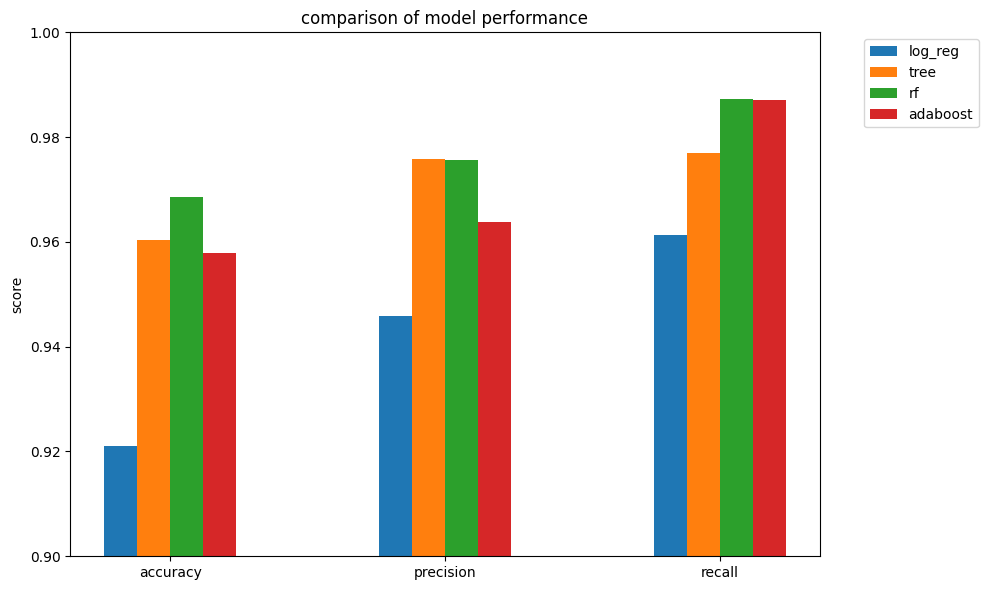

In [ ]:
metrics = ['accuracy', 'precision', 'recall']
model_names = list(tuned_models.keys())
values = results_df.values

x = np.arange(len(metrics))
width = 0.12
n_models = len(model_names)

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_models):
    ax.bar(
        x + (i - (n_models-1)/2) * width,  #center bar
        values[i],  #matric val
        width,
        label=model_names[i]
    )

ax.set_ylabel('score')
ax.set_title('comparison of model performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0.9, 1)
plt.tight_layout()
plt.show()

<h1>Let's look at feature importance of RF

In [ ]:
def plot_rf_feature_importance(rf_model, feature_names):
    importances = rf_model.feature_importances_
    #sort in descending order
    indices = np.argsort(importances)[::-1]
    names = [feature_names[i] for i in indices]

    #plot
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), names, rotation=90)
    plt.tight_layout()
    plt.show()

    #feature ranking
    print("Feature ranking:")
    for i in range(len(importances)):
        print(f"{i+1}. {names[i]} ({importances[indices[i]]})")

    return importances[indices], names

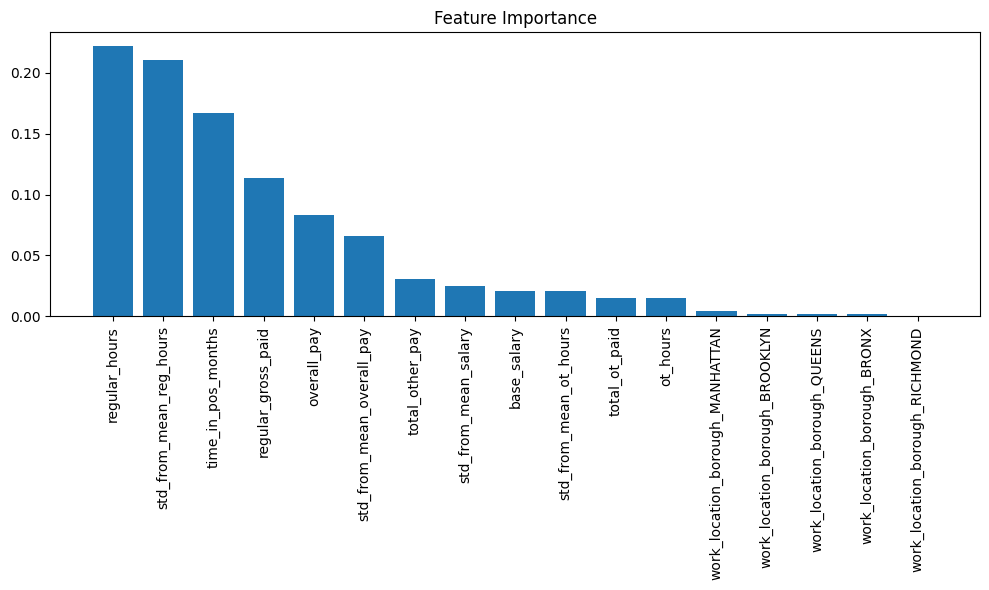

Feature ranking:
1. regular_hours (0.22208044215273218)
2. std_from_mean_reg_hours (0.21071116247722968)
3. time_in_pos_months (0.16679387460703413)
4. regular_gross_paid (0.11393486687912904)
5. overall_pay (0.08363912704263163)
6. std_from_mean_overall_pay (0.06594602066155583)
7. total_other_pay (0.030974772044899786)
8. std_from_mean_salary (0.024807872596433033)
9. base_salary (0.020742547718252666)
10. std_from_mean_ot_hours (0.020630086257858005)
11. total_ot_paid (0.014801079807755428)
12. ot_hours (0.014721828298429863)
13. work_location_borough_MANHATTAN (0.004079436758096179)
14. work_location_borough_BROOKLYN (0.0018993432311969255)
15. work_location_borough_QUEENS (0.001835846968814408)
16. work_location_borough_BRONX (0.0018142845787203876)
17. work_location_borough_RICHMOND (0.0005874079192307372)


In [ ]:
importances, names = plot_rf_feature_importance(tuned_models['rf'], tuned_models['rf'].feature_names_in_)

In [ ]:
feature_imp_df = pd.DataFrame(importances, index=names, columns=['importance score'])
feature_imp_df

,importance score
regular_hours,0.222080
std_from_mean_reg_hours,0.210711
time_in_pos_months,0.166794
regular_gross_paid,0.113935
overall_pay,0.083639
std_from_mean_overall_pay,0.065946
total_other_pay,0.030975
std_from_mean_salary,0.024808
base_salary,0.020743
std_from_mean_ot_hours,0.020630


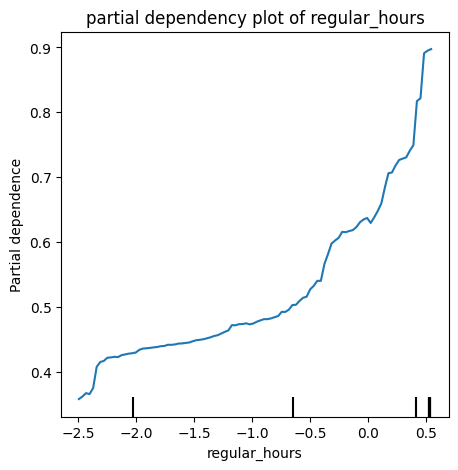

In [ ]:
#look at partial dependency plots for regular_hours, std_from_mean_reg_hours, regular_gross_paid
fig, ax = plt.subplots(figsize=(5, 5))
PartialDependenceDisplay.from_estimator(tuned_models['rf'], X_test_processed, ['regular_hours'], ax=ax)
plt.title('partial dependency plot of regular_hours')
plt.show()

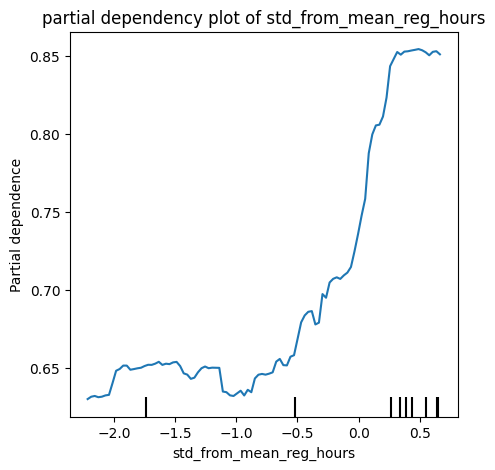

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
PartialDependenceDisplay.from_estimator(tuned_models['rf'], X_test_processed, ['std_from_mean_reg_hours'], ax=ax)
plt.title('partial dependency plot of std_from_mean_reg_hours')
plt.show()

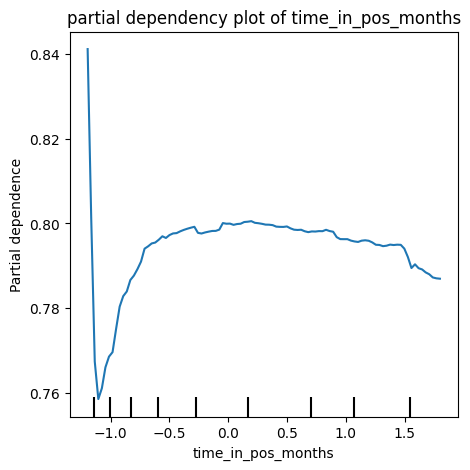

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
PartialDependenceDisplay.from_estimator(tuned_models['rf'], X_test_processed, ['time_in_pos_months'], ax=ax)
plt.title('partial dependency plot of time_in_pos_months')
plt.show()

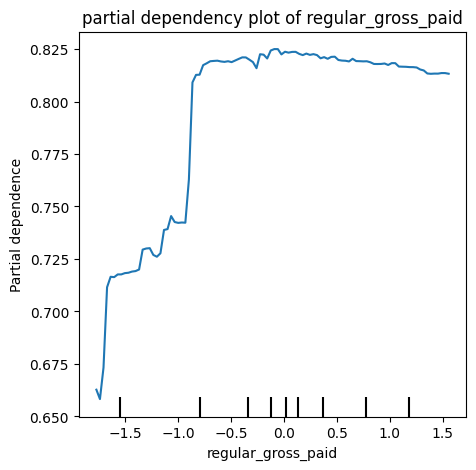

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
PartialDependenceDisplay.from_estimator(tuned_models['rf'], X_test_processed, ['regular_gross_paid'], ax=ax)
plt.title('partial dependency plot of regular_gross_paid')
plt.show()

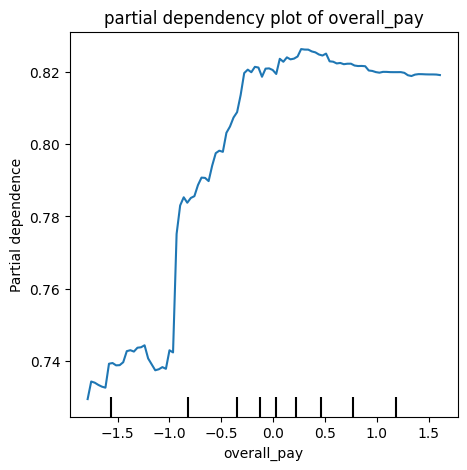

In [ ]:
#overall_pay
fig, ax = plt.subplots(figsize=(5, 5))
PartialDependenceDisplay.from_estimator(tuned_models['rf'], X_test_processed, ['overall_pay'], ax=ax)
plt.title('partial dependency plot of overall_pay')
plt.show()

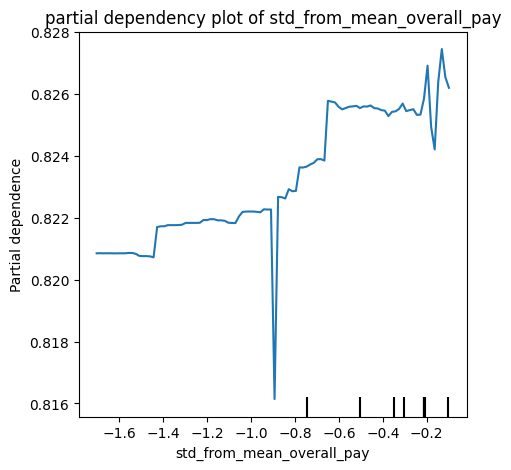

In [ ]:
#std_from_mean_overall_pay
fig, ax = plt.subplots(figsize=(5, 5))
PartialDependenceDisplay.from_estimator(tuned_models['rf'], X_test_processed, ['std_from_mean_overall_pay'], ax=ax)
plt.title('partial dependency plot of std_from_mean_overall_pay')
plt.show()

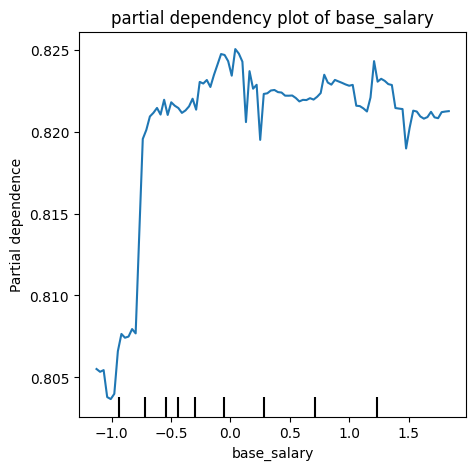

In [ ]:
#base_salary
fig, ax = plt.subplots(figsize=(5, 5))
PartialDependenceDisplay.from_estimator(tuned_models['rf'], X_test_processed, ['base_salary'], ax=ax)
plt.title('partial dependency plot of base_salary')
plt.show()

<h1>Let's also look at feature importance in the other linear model, the log_reg model

In [ ]:
tuned_fitted_logreg_clf = tuned_models['log_reg']
coefs = tuned_fitted_logreg_clf.coef_
coefs

array([[ 0.19773497,  2.24842494, -0.20264278, -0.5789215 ,  0.68596152,
        -0.15590236, -0.40838827,  0.15004257,  0.1135284 , -0.23981157,
         0.49371141,  0.01894847, -0.35916883,  0.12660472,  0.0393276 ]])

In [ ]:
rfe = RFE(tuned_fitted_logreg_clf, n_features_to_select=5)
rfe.fit(X_train_processed, y_train)

rfe_features = X_train_processed.columns[rfe.support_]
print("\nSelected Features by RFE:")
print(rfe_features)


Selected Features by RFE:
Index(['regular_hours', 'ot_hours', 'total_ot_paid', 'time_in_pos_months',
       'work_location_borough_QUEENS'],
      dtype='object')


In [ ]:
rfe = RFE(tuned_models['rf'], n_features_to_select=5)
rfe.fit(X_train_processed, y_train)

rfe_features = X_train_processed.columns[rfe.support_]
print("\nSelected Features by RFE:")
print(rfe_features)


Selected Features by RFE:
Index(['regular_hours', 'regular_gross_paid', 'total_other_pay',
       'time_in_pos_months', 'std_from_mean_reg_hours'],
      dtype='object')
